# Comparing multiple CRNS probes

**For the time being, this notebook is a sandbox.** Step by step, we will migrate mature functions to the actual `cosmicsense` library.

For a detailed explanation of prepprocessing steps, please refer to [from_n_to_theta.ipynb](https://cosmicsense.readthedocs.io/en/latest/notebooks/n_to_theta.html).

In [2]:
# Standard packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
import pandas as pd
import os.path as path
import datetime as dt
import warnings

In [3]:
warnings.simplefilter('once', RuntimeWarning)

In [4]:
import cosmicsense as cs

In [5]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

## Read raw data

#### CRNS records from three probes with different temporal coverage

In [6]:
logid = {
    "soilcan": "1007038",
    "vamos": "1007037",
    "tower": "1007039",
    "road_old_ufz": "1006036",
    "road_ufz": "12110406",
    "road_up": "14040612"
}

In [7]:
installed = {
    "soilcan": dt.datetime(2012,8,18),
    "vamos": dt.datetime(2011,6,4),
    "tower": dt.datetime(2012,8,18),
    "road_old_ufz": dt.datetime(2012,3,17),
    "road_ufz": dt.datetime(2014,7,17),
    "road_up": dt.datetime(2014,5,22)
}

In [8]:
rename_map = {'Time..UTC.': 'dtime', 
              'P..mbar.': 'press',
              'P..mbar..1': 'press1',
              'T1..C.': 'temp1',
              'RH1': 'relhum1',
              'BattV.V.': 'volt',
              'N1C': 'n1c',
              'N1ET.s.': 'nsecs1',
              'N2C': 'n2c',
              'N2ET.s.': 'nsecs2',
              'T2..C.': 'temp2',
              'RH2': 'relhum2'}

In [9]:
fpath = "/media/x/cosmicsense/data/schaefertal/crns/"
crns = {}
for key in logid.keys():
    df = pd.read_csv(path.join(fpath, logid[key]+".txt"), sep="\t")
    df = df.rename(index=str, columns=rename_map)
    df.dtime = pd.to_datetime(df.dtime)
    df = df.set_index("dtime")
    df = df[df.index >= installed[key]]
    df["cph1"] = df.n1c / cs.conv.s_to_h(df.nsecs1)
    try:
        df["cph2"] = df.n2c / cs.conv.s_to_h(df.nsecs2)
    except AttributeError:
        pass
    print(key, end=": ")
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[key] = df

soilcan: 2012-08-18 00:01:00 to 2018-04-06 09:33:00
vamos: 2011-06-04 00:16:00 to 2018-04-06 10:58:00
tower: 2012-08-18 00:05:00 to 2018-04-06 12:15:00
road_old_ufz: 2012-03-17 00:01:00 to 2013-04-02 10:42:00
road_ufz: 2014-07-17 00:06:00 to 2018-04-06 12:56:46
road_up: 2014-05-22 05:16:20 to 2014-09-18 13:17:00


**Correct tower series in 2014 for time shift**

According to `CRS/Schaefertal/Field_campaigns/20141215_schaefertal/20141215_schaefertal_report.doc`, there is a time shift for the data recorded before December 2014. For target time `2014-12-15 13:30:00`, the actual logger time is `2014-10-14 00:18:00`. We correct the data for that time shift.  

In [10]:
# Correct for time shift in tower
shift = dt.datetime(2014,12,15,13,30,0) - dt.datetime(2014,10,14,0,18,0)
x = crns["tower"].index.to_pydatetime()
shiftix = (x > dt.datetime(2014,5,1)) & (x < dt.datetime(2014,11,1))
x[shiftix] = x[shiftix] + shift
crns["tower"] = crns["tower"].set_index(x)

In [11]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])

## Quick view of the raw data

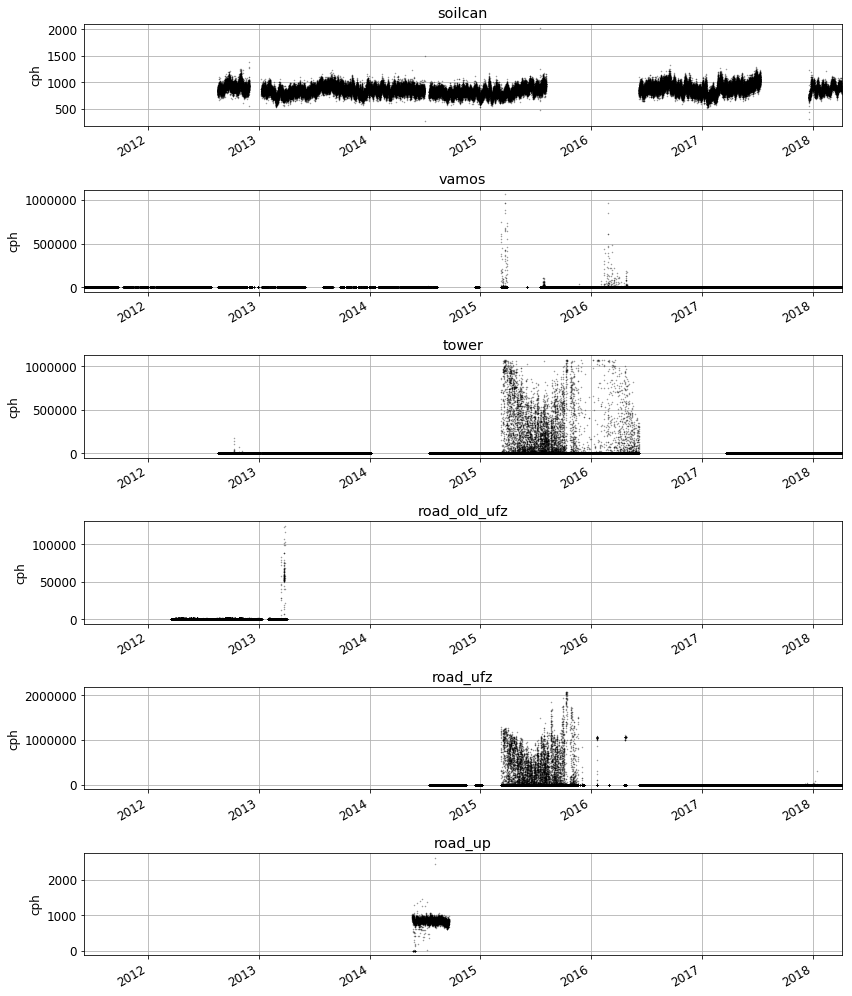

In [12]:
plt.rc('font', **{'size'   : 12})
titles = ["CRNS #1", "CRNS #2", "CRNS #3", "NMDB station counts", "Barometric pressure"]
fig, ax = plt.subplots(nrows=6, figsize=(12,14))

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    crns[key].cph1.plot(ax=ax[i], label=key, linestyle="None", marker=".", ms=1, color="black", alpha=0.4)
    #cb = ax[i].scatter(crns[key].index, crns[key].cph1, c=crns[key].nsecs1, label=key, s=4)
    #fig.colorbar(cb, ax=ax[i])
    ax[i].set_title(key)
    plt.ylabel("Neutron counts")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    ax[i].grid()
    #ax[i].set_ylim(0, 100000)
    #ax[i].legend()    
    
plt.tight_layout()

## Filter spurious signals

Some probes are affected by spurious count rates, presumably due to excess voltage from the solar panels in cases of intense insolation. In order to keep useful parts of the signal, a pragmatic/heuristic filtering approach is applied which could be refined later:

1. Remove entirely unrealisticly count rates higher than 1800 count per hour (cph).
2. Remove count rates from spuriously short count intervals (shorter than 300 seconds)
3. After that, there are still lots of spurious count rates below 2000 cph. These typically occur over periods of a couple of hours. In order to detect these, we compute the maximum count rates over periods of six hours, and then apply a 24-hour-median filter to these 6-hour-maxima. That way, we try to truncate spurios peaks. In order to prevent too aggressive filtering, we add a buffer of 5 % of the median count rates over a period of 24 hours.
4. We then interpolate this upper limit filter to the original timestamp values and use it to remove high values.
5. We remove unrealisticly low count rates (lower than 300 cph), and than apply the same approach (points 3-4) to eliminate spuriously small values.  

In [13]:
plausible_maxcph = 1800
plausible_mincph = 300
plausible_mininterval = 300

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    x[x > plausible_maxcph] = np.nan
    x[x < plausible_mincph] = np.nan
    x[crns[key].nsecs1 < plausible_mininterval] = np.nan
    median24 = x.resample("24H").median()
    # Maxfilter
    max6 = x.resample("6H").max()
    median24max6 = max6.resample("24H").median()
    maxfilter = np.array(median24max6 + 0.05 * median24)
    # Minfilter
    min6 = x.resample("6H").min()
    median24min6 = min6.resample("24H").median()
    minfilter = np.array(median24min6 - 0.05 * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
    crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

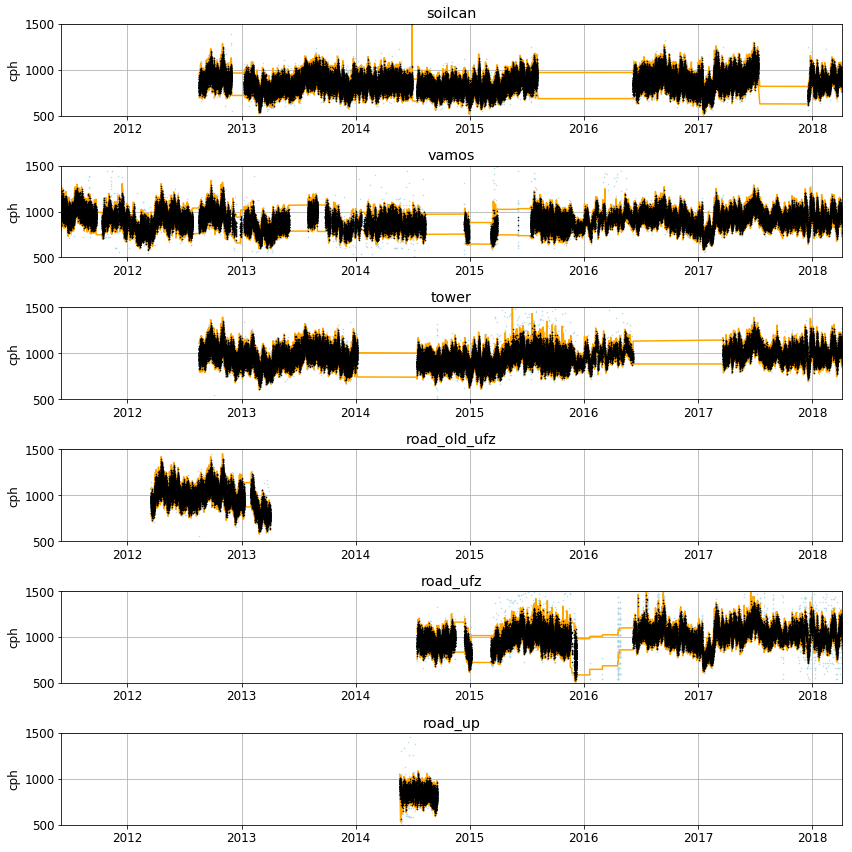

In [14]:
plt.rc('font', **{'size'   : 12})
titles = ["CRNS #1", "CRNS #2", "CRNS #3", "NMDB station counts", "Barometric pressure"]
fig, ax = plt.subplots(nrows=6, figsize=(12,12))

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="lightblue")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(500, 1500)
    ax[i].grid()
    #ax[i].legend()    
    
plt.tight_layout()

## Resample to a common time intervals

In [15]:
min_dtime, max_dtime

(Timestamp('2011-06-04 00:16:00'), Timestamp('2018-04-06 12:56:46'))

In [16]:
dtrange6 = pd.date_range('2010-08-25 12:00:00', '2018-04-06 18:00:00', freq="6H")
dtrange24 = pd.date_range('2010-08-25 00:00:00', '2018-04-07 00:00:00', freq="24H")
crns6h = pd.DataFrame({}, index=dtrange6)
crns24h = pd.DataFrame({}, index=dtrange24)

for i, key in enumerate(crns.keys()):
    crns6h = pd.merge(crns6h, crns[key].cph1_filtered.resample("6H").mean(), 
                      how="left", left_index=True, right_index=True)
    crns6h[key] = crns6h.cph1_filtered
    crns6h = crns6h.drop("cph1_filtered", axis=1)
    # 24 h
    crns24h = pd.merge(crns24h, crns[key].cph1_filtered.resample("24H").mean(), 
                      how="left", left_index=True, right_index=True)
    crns24h[key] = crns24h.cph1_filtered
    crns24h = crns24h.drop("cph1_filtered", axis=1)

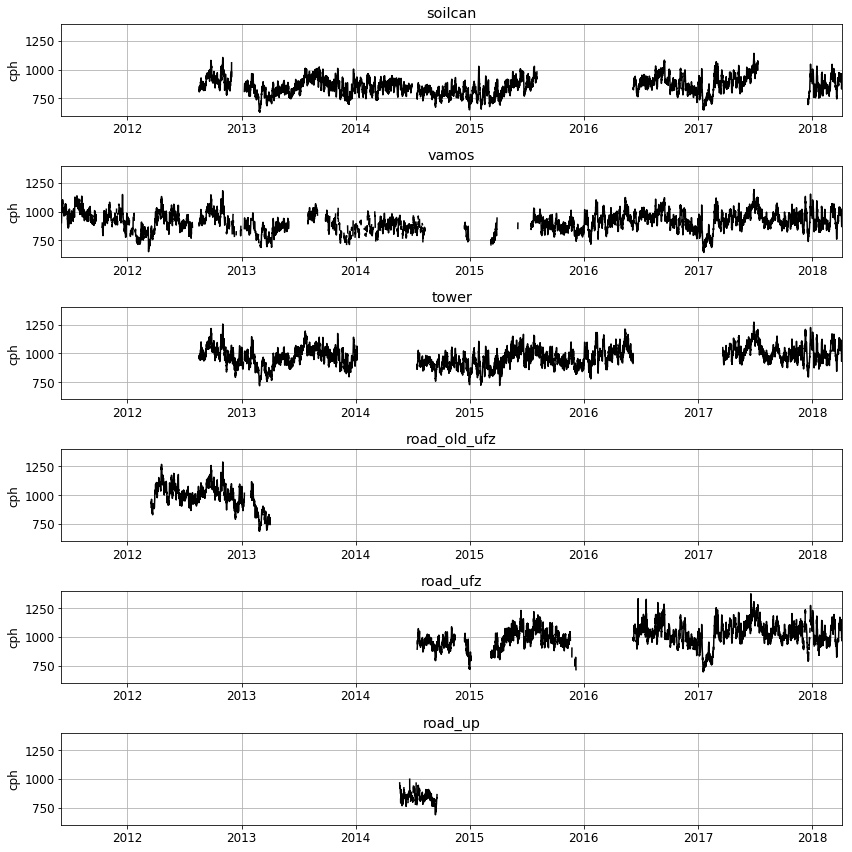

In [17]:
plt.rc('font', **{'size'   : 12})
titles = ["CRNS #1", "CRNS #2", "CRNS #3", "NMDB station counts", "Barometric pressure"]
fig, ax = plt.subplots(nrows=6, figsize=(12,12))

for i, key in enumerate(crns6h.columns):
    ax[i].plot(crns6h.index, crns6h[key], linestyle="-", marker=".", ms=0, color="black")
    #ax[i].plot(crns24h.index, crns24h[key], linestyle="--", marker=".", ms=0, color="green")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(600, 1400)
    ax[i].grid()
    #ax[i].legend()    
    
plt.tight_layout()

In [18]:
#sb.pairplot(crns6h, plot_kws=dict(edgecolor="None", s=4, alpha=0.1))

In [19]:
bounds = range(2011, 2020)

cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(0, 20, 21)
norm = colors.BoundaryNorm(bounds, cmap.N)

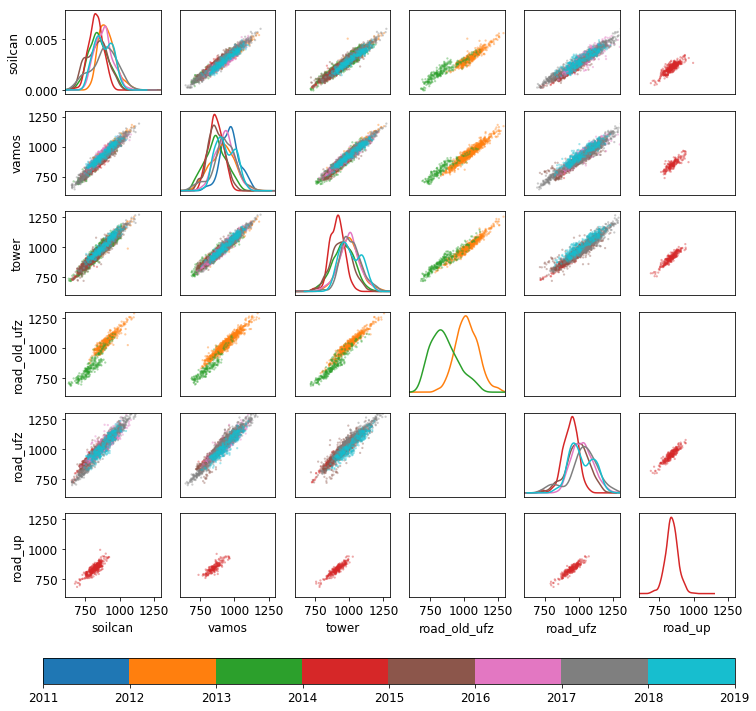

In [20]:
warnings.simplefilter('ignore', RuntimeWarning)
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(12,12))#, sharex=True, sharey=True)

for i, keyi in enumerate(crns6h.columns):
    for j, keyj in enumerate(crns6h.columns):
        if i==j:
            for k, theyear in enumerate(range(2011, 2020)):
                try:
                    crns6h.loc[crns6h.index.year==theyear, keyi].plot.density(ax=ax[j,i], color=cmap(norm(theyear)))
                    ax[j,i].set_ylabel("")
                except:
                    pass
        else:
            cp = ax[j,i].scatter(crns6h[keyi], crns6h[keyj], 
                                 s=5, edgecolors="None", alpha=0.4, c=crns6h.index.year, cmap=cmap, norm=norm)
        #fig.colorbar(cp, ax=ax[i,j])
        if j==len(crns6h.columns)-1:
            ax[j,i].set_xlabel(keyi)
        else:
            ax[j,i].get_xaxis().set_visible(False)
        if i==0:
            ax[j,i].set_ylabel(keyj)
        else:
            ax[j,i].get_yaxis().set_visible(False)
            #ax[j,i].get_yaxis().set_ticks([])
            
        #ax[j,i].grid()
        ax[i,j].set_xlim(600, 1300)
        if not i==j:
            ax[j,i].set_ylim(600, 1300)
        

fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.1, 0.1, 0.8, 0.03])
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', orientation="horizontal")
#plt.colorbar(cp, cax=cax, orientation="horizontal")
#plt.tight_layout()

## Correcting for variations in incoming neutron flux

#### NMBD station data

`nmdb_corr.txt` contains reference (background) neutron counts from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL`, `KIEL2`, and `DRBS` (Dourbes, Belgium), from Jan 2010 to Feb 2019. 

In [21]:
# NMDB data
nmdb = pd.read_csv("../../../data/nmdb_corr.txt", sep=";", comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")

Text(0, 0.5, 'cps')

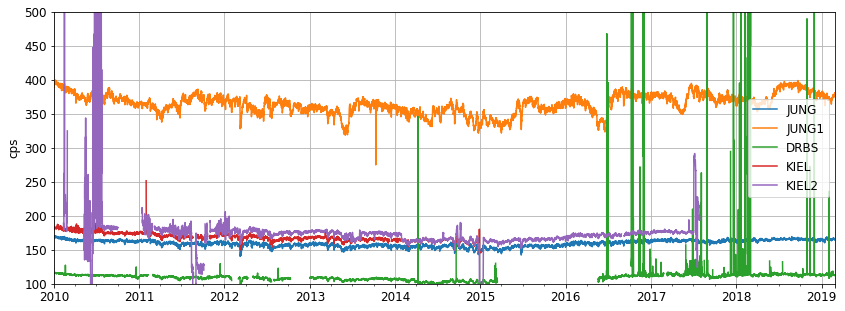

In [22]:
ax = nmdb.plot(figsize=(14,5), grid=True, ylim=(100,500))
ax.set_xlabel("")
ax.set_ylabel("cps")

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch.

**Question: How to objectively quantify $f_{ref}$ from NMDB time series?**

The following figure shows the time series of our CRNS counts and the NMDB data.

In [23]:
nmdb["fi"] = nmdb.JUNG / 150.
fi = pd.merge(crns6h, nmdb.fi, how='left', left_index=True, right_index=True).fi

We use $f_{ref} = 150 cps$ for station `JUNG`, as sugggested by Schroen (2016).

## Correcting for variations in barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

**Question: How do we quantify $p_0$? Based on site average, or just based on standard sea level pressure (1013 mbar)?**

For now, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [24]:
p_0 = cs.conv.strd_baro_pressure
L = 131.6 # g/cm2
fp = pd.DataFrame({}, index=crns6h.index)
for key in crns.keys():
    crns[key]["fp"] = cs.core.corrfact_baro(crns[key].press, p_0, L)
    tmp = crns[key]["fp"].resample("6H").mean()
    tmp = pd.DataFrame({key: tmp})#, index=tmp.index)
    fp = pd.merge(fp, tmp, how='left', left_index=True, right_index=True)

## Correcting for variations in atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

We now apply these functions to the original CRNS time series, then we resample $f_wv$ to 6 hour intervals.

In [25]:
# Compute correction factor from original resolution
fwv = pd.DataFrame({}, index=crns6h.index)
for key in crns.keys():
    h = cs.conv.absolute_humidity(crns[key].temp1, crns[key].relhum1)
    crns[key]["fwv"] = cs.core.corrfact_vapor_rosolem(h)
    # Resample and merge
    tmp = crns[key]["fwv"].resample("6H").mean()
    tmp = pd.DataFrame({key: tmp})#, index=tmp.index)
    fwv = pd.merge(fwv, tmp, how='left', left_index=True, right_index=True)

## Combining the correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

**Attention**: The above formula from Andreasen et al. (2018) might be incorrect. Depending on how $f_p$ is computed (with $p_0 - p$ or $p - p_0$), $f_p$ needs to go to the numerator. E.g. Schroen et al. (2015) compute $f_i$ differently...**need to check this.** 

In [26]:
crns6hc = crns6h.copy()
for key in crns6h.keys():
    crns6hc[key] = crns6h[key] * fwv[key] * fp[key] / fi

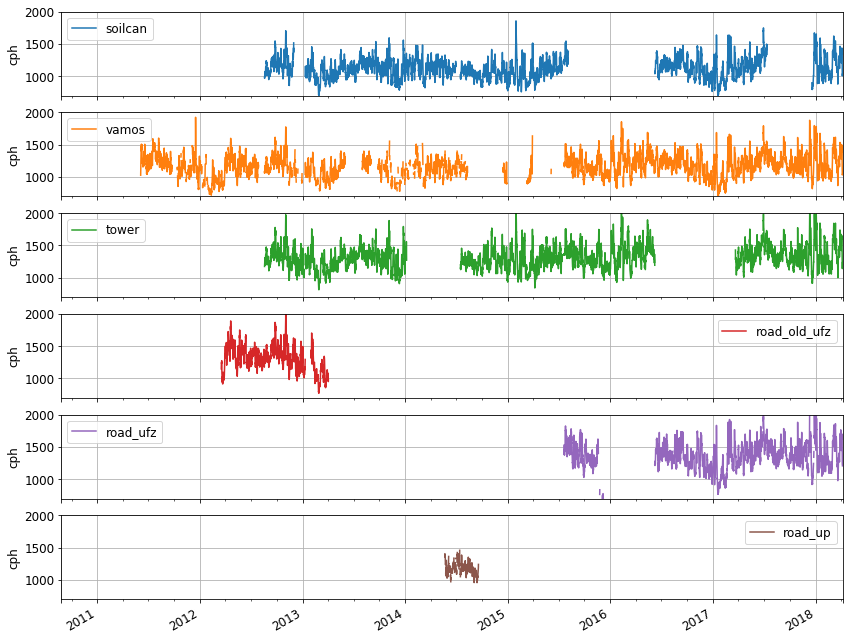

In [27]:
ax = crns6hc.plot(figsize=(14,12), subplots=True, grid=True, ylim=(700,2000))
for ax_ in ax:
    ax_.set_ylabel("cph")

## From corrected neutron counts to soil moisture estimation

Volumetric soil moisture is estimated from a single relation that includes a local calibration parameter $N_0$. [Desilets et al. (2010)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009WR008726) suggested the following one:

\begin{equation*}
\theta = \Bigl(\frac{a_0}{\frac{N_{corr}}{N_0} - a_1} - a_2\Bigl) * \frac{\rho_b}{\rho_w}
\end{equation*}

While $a_0$, $a_1$ and $a_2$ are empirical parameters, soil bulk density $\rho_b$ can be measured or retrieved via transfer functions or literature, the density of water $\rho_w$ is a function of temperature and salinity, although the approximate value of 1000 kg/m3 is can be used without introducing much error as compared to other uncertainties.

The parameter $N_0$ depends on the local hydrogen pool and footprint, and needs to be obtained from calibration with gravimetric soil moisture measurements in the footprint at a defined point in time. For the time being, we just take a wild guess and set $N_0$ to 1500 cph.

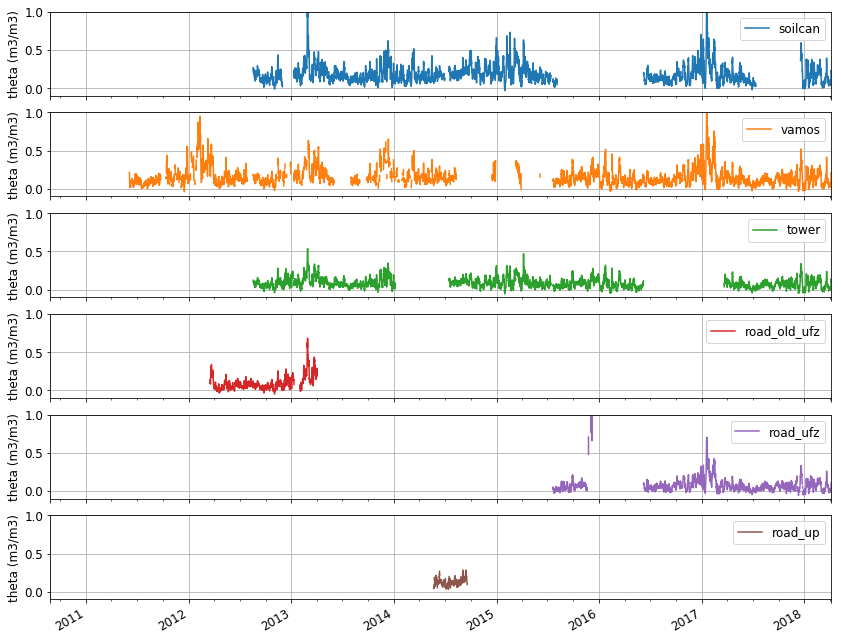

In [28]:
ax = cs.core.n_to_theta_desilets(crns6hc, n0=1500.).plot(figsize=(14,12), grid=True, subplots=True)
for ax_ in ax:
    ax_.set_ylabel("theta (m3/m3)")
    ax_.set_ylim(-0.1, 1)

## Local calibration of $N_0$

In [29]:
samples = pd.read_csv("../../../data/crns_sample1_soil.txt", sep=";")
samples.head()

,Unnamed: 0,date,location,depth,wet_cyl_field_g,wet_cyl_lab_g,dry_cyl_lab_g,cyl_g
0,0,5/8/2013,Center,0-5cm,223.0,131.08,105.72,NaN
1,1,5/8/2013,Center,5-10cm,219.0,222.82,198.96,95.94
2,2,5/8/2013,Center,10-15cm,262.0,265.99,238.09,96.01
3,3,5/8/2013,Center,15-20cm,265.0,268.80,238.22,96.00
4,4,5/8/2013,Center,20-25cm,253.0,257.16,235.74,96.08


In [37]:
vol_cyl = 98 # cm3
samples["theta"] = (samples.wet_cyl_lab_g - samples.dry_cyl_lab_g) / 98.
samples["rho_b"] = (samples.dry_cyl_lab_g - samples.cyl_g) / 98.
samples.depth = [depth.strip() for depth in samples.depth]
samples["depth2"] = np.array([float(depth.split("-")[0]) for depth in samples.depth])
samples.head()

,Unnamed: 0,date,location,depth,wet_cyl_field_g,wet_cyl_lab_g,dry_cyl_lab_g,cyl_g,theta,rho_b,depth2
0,0,5/8/2013,Center,0-5cm,223.0,131.08,105.72,NaN,0.258776,NaN,0.0
1,1,5/8/2013,Center,5-10cm,219.0,222.82,198.96,95.94,0.243469,1.051224,5.0
2,2,5/8/2013,Center,10-15cm,262.0,265.99,238.09,96.01,0.284694,1.449796,10.0
3,3,5/8/2013,Center,15-20cm,265.0,268.80,238.22,96.00,0.312041,1.451224,15.0
4,4,5/8/2013,Center,20-25cm,253.0,257.16,235.74,96.08,0.218571,1.425102,20.0


The sampling design is described in [Rivera Villarreyes, 2013](https://publishup.uni-potsdam.de/opus4-ubp/frontdoor/deliver/index/docId/6730/file/rivera_villarreyes_diss.pdf), p. 104. Letter `A-F` refer to the six angles, numbers `1-4` to the distances `25, 75, 175, and 225` respectively.

In [43]:
samples["r"] = np.nan
for i in range(len(samples)):
    if "1" in samples.location[i]:
        samples.loc[i, "r"] = 25.
    elif "2" in samples.location[i]:
        samples.loc[i, "r"] = 75.
    elif "3" in samples.location[i]:
        samples.loc[i, "r"] = 175.
    elif "4" in samples.location[i]:
        samples.loc[i, "r"] = 225.
    elif samples.location[i]=="Center":
        samples.loc[i, "r"] = 1.

Text(0, 0.5, 'Depth (cm)')

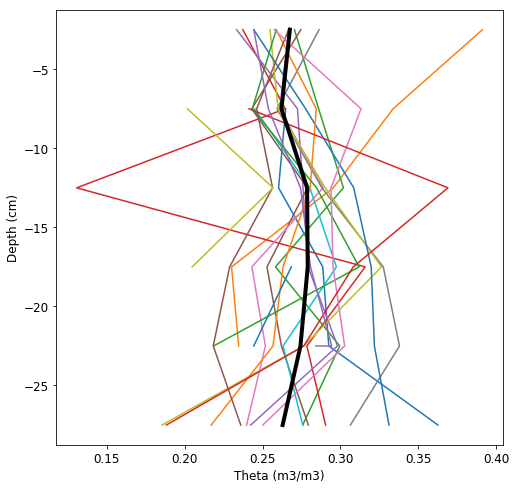

In [31]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
for loc in np.unique(samples.location):
    depths = samples[samples.location==loc].depth2
    theta = samples[samples.location==loc].theta
    #print(theta, depths)
    plt.plot(theta, -depths-2.5)
avg = samples.groupby("depth2").mean()
plt.plot(avg.theta, -avg.index-2.5, linewidth=4, color="black")
plt.xlabel("Theta (m3/m3)")
plt.ylabel("Depth (cm)")

#### Step 1: initial guess

Initial guess of $\theta$ is the average of all samples.

In [46]:
theta_avg = samples.theta.mean()

#### Step 2: penetration depth

In [87]:
# Set parameters which are asssumed to be uniform across the footprint
rho_b = samples.rho_b.mean()
press = crns["tower"]["2013-08-05"].press.mean()
h = np.mean(cs.conv.absolute_humidity(crns["tower"]["2013-08-05"].temp1, crns["tower"]["2013-08-05"].relhum1) )
Hveg = 0.

In [88]:
D_p = cs.core.D86(samples.r, theta=theta_avg, press=press, Hveg=Hveg, rhob=rho_b)

#### Step 3: vertical averaging per profile

In [91]:
profs = pd.DataFrame({}, index=np.unique(samples.location) )
profs["theta"] = np.nan
profs["r"] = np.nan
for prof in profs.index:
    ix = samples.location==prof
    profs.loc[prof, "r"] = np.unique(samples[ix].r)[0]
    vweights = cs.core.vertical_weight_koehli(profs.loc[prof, "r"], samples[ix].depth2, theta_avg, press, Hveg, rho_b)
    profs.loc[prof, "theta"] = np.sum(vweights * samples[ix].theta) / np.sum(vweights)

#### Step 4: horizontal averaging

In [92]:
hweights = cs.core.horizontal_weight_koehli(profs.r, press, Hveg, theta_avg, h)
theta_avg = np.sum(hweights * profs.theta) / np.sum(hweights)

#### Step 5: iterate until `theta_avg` converges 

In [98]:
max_iter = 5
theta_avg = samples.theta.mean()
for i in range(max_iter):
    print(i, np.round(theta_avg,3))
    # step 2
    D_p = cs.core.D86(samples.r, theta=theta_avg, press=press, Hveg=Hveg, rhob=rho_b)
    # step 3
    profs = pd.DataFrame({}, index=np.unique(samples.location) )
    profs["theta"] = np.nan
    profs["r"] = np.nan
    for prof in profs.index:
        ix = samples.location==prof
        profs.loc[prof, "r"] = np.unique(samples[ix].r)[0]
        vweights = cs.core.vertical_weight_koehli(profs.loc[prof, "r"], samples[ix].depth2, theta_avg, press, Hveg, rho_b)
        profs.loc[prof, "theta"] = np.sum(vweights * samples[ix].theta) / np.sum(vweights)
    # step 4
    hweights = cs.core.horizontal_weight_koehli(profs.r, press, Hveg, theta_avg, h)
    theta_avg = np.sum(hweights * profs.theta) / np.sum(hweights)
    


0 0.271
1 0.216
2 0.214
3 0.214
4 0.214
